A notebook to calculate data for the Bayesian bot (analogous to training for ML bots)

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import pickle
import ast
import json

In [5]:
# Loads M19 drafts
draftPath = "../../data/standardized_m19/drafts_train.pkl"
drafts = None
with open(draftPath, "rb") as f:
    drafts = pickle.load(f)

# Loads ratings
ratingPath = "../../data/standardized_m19/standardized_m19_rating.tsv"
nameList = pd.read_csv(ratingPath, delimiter="\t", converters={6:ast.literal_eval})
nameList['index'] = range(len(nameList))
nameList = nameList.set_index('index')
nameList[1:5]

,Name,Casting Cost 1,Casting Cost 2,Card Type,Rarity,Rating,Color Vector
index,,,,,,,
1,Act_of_Treason,2R,none,Spell,C,2.0,"[0, 0, 0, 1, 0]"
2,Aegis_of_the_Heavens,1W,none,Instant,U,1.9,"[1, 0, 0, 0, 0]"
3,Aerial_Engineer,2UW,none,Creature,U,3.0,"[1, 1, 0, 0, 0]"
4,Aether_Tunnel,1U,none,Spell,U,2.0,"[0, 1, 0, 0, 0]"


### Calculate all the stats

In [6]:
nCardsInSet = len(nameList)
nCoDraft = np.zeros([nCardsInSet,nCardsInSet]) # Asymmetric co-draft matrix, numerator
dCoDraft = np.zeros([nCardsInSet,nCardsInSet]) # Denominator
nChoice = np.zeros([nCardsInSet,nCardsInSet]) # Asymmetric choice matrix, numerator
dChoice = np.zeros([nCardsInSet,nCardsInSet]) # Denominator
pFull = np.zeros(nCardsInSet) # Total number of times each card was drafted

In [4]:
# Main loop (very slow, unfortunately: 18 min for 5,000 drafts)

nDrafts = len(drafts)  # <----- Replace 100 with len(drafts) to run on the full dataset (86,359)
tic = time.time()
for iDraft in range(nDrafts): #range(len(drafts)):
    if iDraft % 1000 == 0:
        print()
        print("Draft #%d/%d" % (iDraft,nDrafts), end = '')
    if iDraft % 100 == 0:
        print('.', end = '')
    draft = drafts[iDraft]
    collection = np.zeros(nCardsInSet)
    for pack in draft:     
        packVector = np.zeros(nCardsInSet)
        for cardName in pack:            
            pos = nameList[nameList.Name==cardName].index[0]            
            packVector[pos] += 1  # Mark the card
            if cardName==pack[0]: # If the first card in the pack, note it, as the Human picked it
                humanCard = pos

        humanPick = np.zeros(nCardsInSet)
        humanPick[humanCard] = 1
        # Preference matrix. A_ij counts how many times card i won over card j:
        nChoice += np.outer(humanPick,packVector)
        dChoice += np.outer(packVector,packVector)
        # Co-draft matrix, asymmetric. A_ij counts how many times i was drafted, with j already in collection:
        nCoDraft += np.outer(humanPick,collection)
        dCoDraft += np.outer(packVector,collection) # Denominator: how many times it could have been drafted
        
        collection[humanCard] += 1 # Update collection
                
        #print(iDraft,iCard,nameList.iloc[humanCard]['Name'],nameList.iloc[humanCard]['colors'],
        #                   nameList.iloc[botCard]['Name'],  nameList.iloc[botCard]['colors'])
        
    # -- Out of drafting: Final collection
    # Symmetric variant of co-draft matrix (assumed to be inferior than asymmetric, but not deleted for now)
    # A_ij counts how many times cards i and j were co-drafted (symmetric matrix)
    # pCoDraft += np.outer(collection,collection)-np.diag(collection) # Diagonal: n^2-n = n(n-1)
    
    pFull += collection

# -- Out of loop
print('Done. Time elapsed (minutes): %5.1f' % (float(time.time() - tic)/60))


Draft #0/86359..........
Draft #1000/86359..........
Draft #2000/86359..........
Draft #3000/86359..........
Draft #4000/86359..........
Draft #5000/86359..........
Draft #6000/86359..........
Draft #7000/86359..........
Draft #8000/86359..........
Draft #9000/86359..........
Draft #10000/86359..........
Draft #11000/86359..........
Draft #12000/86359..........
Draft #13000/86359..........
Draft #14000/86359..........
Draft #15000/86359..........
Draft #16000/86359..........
Draft #17000/86359..........
Draft #18000/86359..........
Draft #19000/86359..........
Draft #20000/86359..........
Draft #21000/86359..........
Draft #22000/86359..........
Draft #23000/86359..........
Draft #24000/86359..........
Draft #25000/86359..........
Draft #26000/86359..........
Draft #27000/86359..........
Draft #28000/86359..........
Draft #29000/86359..........
Draft #30000/86359..........
Draft #31000/86359..........
Draft #32000/86359..........
Draft #33000/86359..........
Draft #34000/86359........

In [8]:
# --- Final adjustments to everything
# Set self-comparisons to zero for nChoice, as they don't matter:
np.fill_diagonal(nChoice,0) # Weird method that modifies its argument instead of returning something

# Old version
#pChoice = nChoice/np.maximum(1,nChoice) # Calculate probabilities
#pCoDraft = nCoDraft/np.maximum(1,nCoDraft)

# New version
pChoice = nChoice/np.maximum(1, dChoice) # Calculate probabilities
pCoDraft = nCoDraft/np.maximum(1, dCoDraft)

In [9]:
#pChoice = nChoice/np.amax(nChoice, axis = 1)
print(np.amax(pChoice))
print(pChoice[1:5, 1:5])

0.9565217391304348
[[0.         0.10142588 0.0696347  0.07931969]
 [0.03013183 0.         0.02507599 0.02553685]
 [0.14859209 0.16945289 0.         0.15494012]
 [0.08263095 0.0957632  0.06811377 0.        ]]


In [10]:
# -- Troubleshooting: look at the attraction data
print(nameList[['Name','Rarity','Casting Cost 1']][0:7])
# A_ij means that card i (row) was considered, when card j (column) was already present
# Empty row means that this card is rarely considered against other cards (rare?)
# Full column means that this card is drafted early and everything is considered against it
print(nCoDraft[0:7,0:7].astype(int))
print('/')
print(dCoDraft[0:7,0:7].astype(int))
# Aegis (2, good) is often seen when Endurance (0, bad) is present (2,0), but not the other way around (0,2)

Name Rarity Casting Cost 1
index                                              
0          Abnormal_Endurance      C             1B
1              Act_of_Treason      C             2R
2        Aegis_of_the_Heavens      U             1W
3             Aerial_Engineer      U            2UW
4               Aether_Tunnel      U             1U
5      Aethershield_Artificer      U             3W
6          Ajani's_Last_Stand      R            2WW
[[ 5599  3738   539   726   740   506   300]
 [ 3389 11188   672   894  1114   701   322]
 [  652   791   447   666   313   443   177]
 [  776  1014   416  2987   872  1091   293]
 [  705   905   258   998  1019   405   115]
 [  254   334   223  1020   229   712   166]
 [  162   189    92   166    66   126    67]]
/
[[23394 31954  5811 13813  9872  7883  3284]
 [24859 35881  6422 15568 11115  8725  3661]
 [ 9870 14048  2479  6222  4138  3483  1452]
 [ 6390  9541  1812  4626  3143  2224   965]
 [ 7743 11028  2037  5082  3490  2711  1138]
 [ 4193  5982 

[[0.60457834 0.3002892  0.26656775 0.16447667 0.22109352 0.17917847]
 [0.3659432  0.89877892 0.33234421 0.20253738 0.33283537 0.24822946]
 [0.07040276 0.06354434 0.22106825 0.15088355 0.09351658 0.15686969]
 [0.08379225 0.08145887 0.20573689 0.67671047 0.26053182 0.38633144]
 [0.07612569 0.07270244 0.12759644 0.22609878 0.30445175 0.1434136 ]
 [0.02742684 0.02683162 0.11028684 0.23108292 0.06841948 0.25212465]]


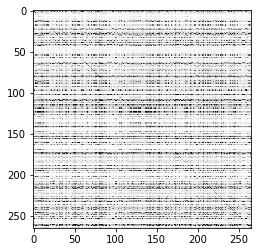

In [38]:
plt.imshow(pCoDraft, cmap="Greys");
print(pCoDraft[0:6,0:6])

array([[0.        , 0.40071942, 0.47089487, 0.35531629, 0.39927074],
       [0.53939855, 0.        , 0.65508254, 0.49259758, 0.48040109],
       [0.06661591, 0.08057554, 0.        , 0.04441454, 0.04010939],
       [0.28892273, 0.28093525, 0.19374457, 0.        , 0.18869644],
       [0.18956985, 0.19748201, 0.14335361, 0.12247645, 0.        ]])

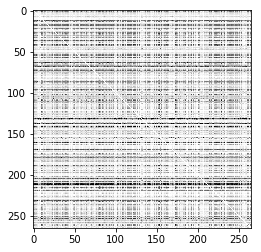

In [39]:
plt.imshow(pChoice, cmap="Greys");
pChoice[0:5,0:5]

In [40]:
pFull[1:19]

array([29601.,  5652., 11657.,  8555.,  5316.,  2159.,  8313., 14525.,
        2398.,  7303.,  5363., 21544., 29929.,  3952.,  3961.,  5198.,
       24481., 23137.])

In [7]:
nChoice = np.loadtxt('bots_data/nChoice.csv',  delimiter=",")
dChoice = np.loadtxt('bots_data/dChoice.csv',  delimiter=",")
nCoDraft = np.loadtxt('bots_data/nCoDraft.csv',  delimiter=",")
dCoDraft = np.loadtxt('bots_data/dCoDraft.csv',  delimiter=",")

In [11]:
# --- Save everything
np.savetxt('bots_data/bayes_pCoDraft.csv', pCoDraft, delimiter=",")
np.savetxt('bots_data/bayes_pChoice.csv', pChoice, delimiter=",")
np.savetxt('bots_data/bayes_pFull.csv', pFull, delimiter=",")
np.savetxt('bots_data/nChoice.csv', nChoice, delimiter=",")
np.savetxt('bots_data/dChoice.csv', dChoice, delimiter=",")
np.savetxt('bots_data/nCoDraft.csv', nCoDraft, delimiter=",")
np.savetxt('bots_data/dCoDraft.csv', dCoDraft, delimiter=",")
# Save card names, to match later
pd.DataFrame(nameList['Name']).to_csv('bots_data/bayes_names.csv',index=False)

In [42]:
# Playground for co-occurrence matrix
# Test for denominator. Let's say it's rare, uncommon, common (good-mid-bad)
c = np.zeros([3,3])
c += np.outer(np.array([1,1,1]),np.array([0,0,0]))
c += np.outer(np.array([0,1,1]),np.array([1,0,0]))
c += np.outer(np.array([0,0,1]),np.array([1,1,0]))
print(c.astype(int))
# A_ij means that card i (row) was considered, when card j (column) was already present

[[0 0 0]
 [1 0 0]
 [2 1 0]]


In [43]:
# Playground for preference matrix
c = np.zeros([3,3])
# A_ij counts how many time card i (row) won over card j (column)
# Now let's have some history
c += np.outer(np.array([0,1,0]),np.array([1,1,0])) # 1 won over 0
c += np.outer(np.array([1,0,0]),np.array([1,1,0])) # 0 won over 1
c += np.outer(np.array([0,1,0]),np.array([1,1,0])) # again (2nd time)
c += np.outer(np.array([1,0,0]),np.array([1,1,0]))
c += np.outer(np.array([0,1,0]),np.array([1,1,0])) # 3d time
c += np.outer(np.array([1,0,0]),np.array([1,1,0]))
c += np.outer(np.array([0,1,0]),np.array([1,1,0])) # 4th time
c += np.outer(np.array([1,0,0]),np.array([1,1,0]))
c += np.outer(np.array([0,0,1]),np.array([1,1,1])) # 2 won over both, once
np.fill_diagonal(c,0)
print(c.astype(int))

print(np.matmul(np.log(c+1),np.array([1,1,1])))

[[0 4 0]
 [4 0 0]
 [1 1 0]]
[1.60943791 1.60943791 1.38629436]
